# Linear regression with Professor Mittens, a.k.a. recipe for linear regression.

## Overview

In this notebook we will learn how to use regression to study the factors that affect the number of pats cats will recieve. This will start with a visual inspection of the data, followed by the development of a linear model to explain the data. Along the way we will answer a few questions such as: does coat colour influence the number of pats, is a long coat better than a short coat, and how important is the volume of a meow.

## Specifying regression models

A very popular way to describe regression models is with "formulae" as popularised by R. The [R documentation on formulae](https://cran.r-project.org/doc/manuals/R-intro.html#Formulae-for-statistical-models) is a good place to learn how to use these properly. For example, here is the syntax we will use today,

- `y ~ x1 + x2` will make a linear model with the predictors $x_1$ and $x_2$.
- `y ~ x1 * x2` includes the terms $x_1 + x_2 + x_1x_2$
- `y ~ x1 : x2` includes *just* the interaction term $x_1x_2$
- `y ~ C(x)` specifies that $x$ is a catagorical variable **NOTE** this is not necessary in R.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import altair as alt
from functools import reduce

## Helping cats get more pats

Professor Mittens in interested in helping cats optimise the number of pats they can get. To learn more about this, he has interviewed 1000 cats and taken measurements of their behaviour and appearance. The data in `cat-pats.csv` contains measurments of the following:

- `time_outdoors` is the number of hours that the cat is out of their primary dwelling,
- `coat_colour` is either tortoiseshell, white, or "other" encoded as integers 1, 2, and 3 respectively,
- `weight` is the weight of the cat in kilograms,
- `height` is their height in centimeters,
- `loudness` is a measure of how loud their meow is, the units are not known,
- `whisker_length` is the length of their whiskers in centimeters,
- `is_longhaired` is a Boolean variable equal to 1 if the cat is of a longhaired breed and 0 if it is of a shorthaired breed,
- `coat_length` is the length of their fur in centimeters,
- and `num_pats` is the number of pats they received on the day they were interviewed.

The variable we are interested in explaining is `num_pats`. Although this is a discrete variable, we will ignore this aspect of the data and consider it as a continuous value. This is a useful simplifying assumption, as you learn more about regression, in particular generalized linear models, you will see additional ways to handle this. For this example, you can consider it a continuous variable though.

The types of questions that Professor Mittens is interested in answering are as follows:

1. Do any of the variables correlate with the number of pats that the cats recieve?
2. Under a naive model, how much of the variability in pats can they explain? Do all the variables need to be included?
3. Does the coat colour matter?
4. Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?
5. **If a cat can choose to spend more time outdoors, or practise meowing louder, which will get them more pats?**

### Read in the data and generate some scatter plots to see if there are any good predictors of the number of pats

The data is in the file `cat-pats.csv` so read this into a data frame using `pd.read_csv` and go from there. I have used altair to generate my scatter plots based on [this example](https://altair-viz.github.io/gallery/scatter_matrix.html) but you can use whatever you feel most comfortable with. It might be useful to use colour to see if `coat_colour` and `is_longhaired` are important. 

### Question 1 - Do any of the variables correlate with the number of pats that the cats recieve?

Based on these figures, what variables appear to relate to the number of pats? What do you notice about the catagorical variables `coat_colour` and `is_longhaired`?

In [2]:
cat_df = pd.read_csv("cat-pats.csv")
#display(cat_df.head())
#display(cat_df.info())

In [3]:
cat_df

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
0,7.968883,3,3.474459,24.679895,2.776442,8.350615,1,6.306728,38
1,12.481158,3,3.476376,25.236722,3.263675,8.182506,0,3.059234,52
2,2.229639,3,3.934887,23.551737,2.215878,7.673753,1,7.667451,32
3,10.978511,1,3.802978,24.247849,4.799470,8.689976,1,7.169723,48
4,8.674765,3,4.234895,24.425628,2.496709,8.073498,0,5.605462,50
...,...,...,...,...,...,...,...,...,...
995,12.198816,2,3.884863,22.834104,3.752737,7.650264,1,7.519727,39
996,2.519829,3,4.694109,23.331903,2.889438,7.595348,0,3.709409,35
997,6.380990,2,4.184664,24.907993,3.289389,8.040561,1,6.511048,41
998,2.484029,1,3.705406,22.562536,3.567503,7.722303,0,3.792457,30


In [4]:
col_names = cat_df.columns.tolist() # convert columns to list
predictor_names = col_names.copy()# take a copy to avoid manipulating source
predictor_names.remove("num_pats") # create predictor set my removing exploratory / dependent variable 

alt.Chart(cat_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)), # channel with repeated chart tied to the column (mapped to X)
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)), # channel with repeated chart tied to the row (mapped to Y)
    color = "is_longhaired:O"# depending on whether you put  0 or N, it chooses different colors as it assumes different data types for the variable in question
).properties(
    width=100,
    height=100
).repeat(
    row=["num_pats"],
    column=predictor_names
)

#?alt.repeat

alt.RepeatChart(...)

## Observations - Question 1
On "is_longhaired"
- We compute a facet grid of correlation plots which shows the correlation between Y and each of our predictors X while applying hue on "is_longhaired"
- In terms of correlations, it appears that time outdoors and coat_length are correlated with num_pats. Whereas the former appears positively correlated, the latter shows a negative correlation 
- the plots further showed that the the categories of the categorical variable "is_longhaired" visibly splits the scatter plot into sub-clusters - especially for the predictor "coat_length".This already hints at the suitability of modeling this categorical variable as interaction term, for example with time_outdoors and coat_length as the effect of these variables on num_pats changes as we alternate between the categories. As this violates the additivity assumption underlying linear regression, modeling this relationship as interaction term might take appropriate account of the observed dynamics 

On "coat_colour"
- The same analysis on coat_colour yields less actionable results. Categories do not appear distinct  sub clusters on first sight. At the same time, scatter plots are less ameanable to categorical variables with 2+ categories. Additional examination will be required to inform  a judgement call on this variable 

In [5]:
alt.Chart(cat_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color = "coat_colour:N"
).properties(
    width=100,
    height=100
).repeat(
    row=["num_pats"],
    column=predictor_names
)

alt.RepeatChart(...)

### Partial answer

- Based on the plots, it looks like the time the cat spends outdoors and their coat length (both whether they are a longhaired breed and the actual length of their fur) are important.
- Also note that when you colour based on whether the breed is a long hair some of the data seems to cluster while this is not the case in for the colour of the coat.

### Compute the correlation between each variable and the number of pats, what looks important

### Question

Does the the correlation matrix raise any further questions? Does it handle the catagorical variables correctly?

In [6]:
matrix_corr = cat_df.corr()

threshold = 0.7

matrix_corr =matrix_corr > threshold

columns = matrix_corr.columns.tolist()

for col in columns:
    matrix_corr[col] = matrix_corr[col].map(lambda x: "x" if x == True else "")

print(f"Instances with a correlation coefficent > {threshold:.0%}\n")
display(matrix_corr)

Instances with a correlation coefficent > 70%



,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
time_outdoors,x,,,,,,,,
coat_colour,,x,,,,,,,
weight,,,x,,,,,,
height,,,,x,,x,,,
loudness,,,,,x,,,,
whisker_length,,,,x,,x,,,
is_longhaired,,,,,,,x,x,
coat_length,,,,,,,x,x,
num_pats,,,,,,,,,x


### Partial answer

- There is a strong relationship between whisker length and height which we had not seen in the plots above.
- Since the catagorical variables were encoded as numbers they are being handled as qualitative variables so the reported values are not correct for those rows/columns.

### What is $R^2$?

Sometimes called the *coefficient of determination*, this statistic measures the proportion of the variance in the response variable that is explained by the regression model. In the case of simple linear regression it is just the correlation squared, it can also be calculated as the ratio of the regression sum of squares and the total sum of squares. 

$$
R^2 = \frac{\text{RegSS}}{\text{TSS}}
$$

It can be thought of as the proportion of the total variance that is explained by the regression model.

### What is an *adjusted* $R^2$?

For a fixed number of observations, as the number of covariates increases you can get explain as much of the variability as you want! The adjusted $R^2$ is a way to penalise using too many covariates. The adjusted $R^2$ for a model with $n$ observations and $p$ coefficients is given by the following:

$$
\tilde{R}^2 = 1 - \frac{n - 1}{n - p}\left(1 - R^2\right)
$$

### Question 2a -  Under a naive model, how much of the variability in pats can they explain?

Run an ordinary linear regression with all of the variables and see what percentage of the variability in the number of pats is explained. Make sure that you have used the catagorical variables correctly. Can be be confident in rejecting the null hypothesis that none of these variables is associated with the number of pats received?

In [7]:
lm_1 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + whisker_length + C(is_longhaired) + coat_length", cat_df).fit()
print(lm_1.summary())

#LEARNING
# the f in smf stands for formula. sm would require you to construct your own design matrix
# if you get T2 you get coefficint beta more less relative to the base categories 
# if you get T3 it is T3-T2 higher or lower than T2 and T3 higher or lower than T1 
# identificability problem for whiseker length & coat_ length > they might have individually high correlations with y but once included
#jointly in the model, they loose effect
#the level of R squared that is considered good is domain-specific. Since humans are complex, we are not expecting to explain every single variance
#as compared to clinical trial 

#sample repeatdly until you get too cats that are similar in every respect other than their hair length, a cat with long hair would receive
# on average 8.7 pads less than a short hair one 

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     146.4
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          4.17e-175
Time:                        18:51:02   Log-Likelihood:                -3240.1
No. Observations:                1000   AIC:                             6500.
Df Residuals:                     990   BIC:                             6549.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.50

## Observations - Question 2a
Top level
- No major difference between R-squared and Adj. R-squared > the model does not seem to suffer from too many variables that make non-material contributions to the amount of variable explained in the response variable 
- F-Statistic is high with a very small probability of finding F-statistic larger than the one observed for this sample > We can reject H0 and conclude that at least one of our predictors is related to the response variable "num_pats"

Body 
- the predictor coefficients whisker_length & loudness & coat_length do not appear to be associated with our response variable as their coefficient are statistically non-significant. This manifests itslef in various columns of the table > small absolute coefficent values, also in relation to their respective standard errors, small t-statistics and p-values above the significance level as well as confidence intervals which do include 0 
- There is strong statistical evidence that the Categorical variable "Coat_colour" is associated with the response variable. A cat of colour T2 is predicted to receive one average 2.7 more pets than cat of colour T0 all other things equal. In the same vein. A cat of colour T3 is predicted to receive one average 8.3 more pets than cat of colour T0. Following a similar interpretation, long_haired cats receive on average 8.7 less pads as compared to cats that are shorthaired all other predictors held constant 
- In regards of the variable coefficients deemed non-significant, we might further investigate for collinearity. In a multivariate setting,this can be done by looking at VIF. A symptom which would strengthen this suspicion would be comparing whether whisker length exercises significant effect on the response variable in a simple linear regression model while loosing its significance in a multivariate setting as we have seen. As multivariate linear regression measures  the partial effect of each predictor holding all other effects constant, we might infer that the variable makes no genuine contribution as its effect is already carried out by neigbouring predictors. Hence, in a simple linear regression setting, whisker length might just be a surrogate enacting an effect on behalf of an other variables to which it is highly correlated but which, at the same time, is not yet included in the model

### MY LEARNINGS 
Useful Links
- https://sites.google.com/site/statisticsforspreadsheets/regression-modeling/influence-plot
- https://www.statisticshowto.com/what-is-a-standardized-residuals/

<ins>The influence plot</ins>
- helps you identify individual data points that might have undue influence over the fitted regression equation. 
- Unusual data points can be unusual because they have an unusual combination of X values, or because their Y value is unusual given their X values.
- Points that have unusual X’s are called “high leverage points,” and points with unusual Y values (given X) are “outliers.” Finding outliers is easy, you just look for
observations with large residuals (in absolute value), which you can do on a residual plot.
- Finding high leverage points is harder than you might think, because in a regression with several X’s, an observation might have typical values on each variable, but the combination is unusual. While one can use the correlation coefficient to assess the relationship between two variables, this is not possible anymore in a multi-variate setting
- Each point in a regression “pulls” the regression function towards its Y value. Points with high leverage can pull harder than points with low leverage. 
- High leverage points have the opportunity to exert an undue influence over the regression line, but do they use it? Some high leverage points have Y values right where they’d be predicted by a regression that was fit with the point excluded. These points aren’t particularly influential.
- “Cook’s distance” measures how much the predicted values from the regression would change if each observation were removed from the data used to fit the model. Each observation has a Cook’s distance, but the number computed for each observation measures how far the predictions would move for all the points in the training data.

<ins>Standardized residual</ins>
- (observed count – expected count) / √expected coun

<ins>Studentized residual</ins>
- In statistics, a studentized residual is the quotient resulting from the division of a residual by an estimate of its standard deviation. It is a form of a Student's t-statistic, with the estimate of error varying between points.



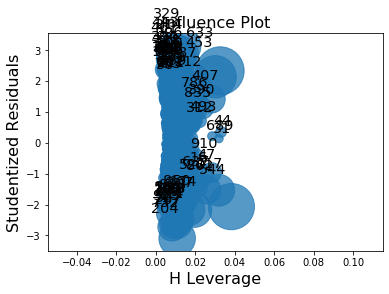

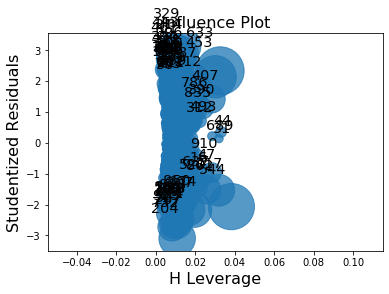

In [8]:
import matplotlib.pyplot as plt

sm.graphics.influence_plot(lm_1, criterion="cooks")
#sm.graphics.plot_fit(lm_1, "coat_length") # for outlier detection


#?sm.graphics.influence_plot
#?sm.graphics.plot_fit

## Observations - Question 2
<ins>Influence Plot</ins>
- it can be difficult to decide how large a residual needs to be before we consider the point to be an outlier (e.g. you would not consider 717 an outlier if you dotn consider a 544 an outlier.)
- instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual ei by its estimated standard studentized residual
- considering Leverage,each point in a regression “pulls” the regression function towards its Y value. Points with high leverage can pull harder than points with low leverage. 
- Complication: multiple linear regression with many predictors, it is possible to have an observation that is well within the range of each individual predictor’s values, but that is unusual in terms of the full set of predictors.
- Remedy: We calculate an observations h-value, the quantification of leverage which increases as xi becomes more distant from the mean 
- Complication:If a point is ascribed high leverage, the question remains, whether  use it? Some high leverage points have Y values right where they’d be predicted by a regression that was fit with the point excluded. These points aren’t particularly influential.
- Remedy: “Cook’s distance” - represented by the size of the bubbles -  measures how much the predicted values from the regression would change if each observation were removed from the data used to fit the model. Each observation has a Cook’s distance, but the number computed for each observation measures how far the predictions would move for all the points in the training data.

<ins>Residual Plot</ins>
- Analysis: the observation on the very right side of the x-Axis stands out. since the x value is far away from the rest of the observation set, one might suspect high leverage.This is further confirmed by the influence plot. At the same time, the difference between fitted and actual value is notable which motivates the conclusion that this point might be an outlier with high leverage. Subsetting our df for this value and comparing to the actual mean & median confirms this suspicion

In [8]:
cat_df[543:546]

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
543,3.361139,1,3.685847,23.939379,2.483834,8.252826,1,6.629628,35
544,3.294114,3,4.231563,21.866053,3.715987,7.105908,1,12.573740,19
545,8.039386,1,3.729648,23.569140,2.247019,7.714122,1,5.631064,23


In [9]:
cat_df.describe()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.035366,1.96700,3.991534,23.986785,3.256364,8.171950,0.494000,5.461403,38.086000
std,3.584645,0.81889,0.500643,1.140039,0.840721,0.468196,0.500214,1.903036,9.437567
min,0.154231,1.00000,2.430003,19.939328,1.616797,6.682087,0.000000,1.711976,15.000000
25%,3.350706,1.00000,3.668124,23.198559,2.625019,7.867283,0.000000,3.879987,31.000000
50%,5.396088,2.00000,3.997326,23.969937,3.318276,8.147573,0.000000,5.307417,38.000000
75%,8.008499,3.00000,4.333097,24.727161,3.854054,8.466936,1.000000,6.938242,44.000000
max,24.000000,3.00000,5.493976,28.184376,6.179538,9.769214,1.000000,12.573740,81.000000


### Question 2b: Is colinearity an issue in this model? Do all of the variables need to be included?

Compute the VIF to see if there is a concerning amount of colinearity between any of the covariates.

### MY LEARNINGS

- [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor)

<img src="VIF.png" style="width: 800px;"/>

In [136]:
col_names = cat_df.copy().columns.tolist()
col_names.remove("num_pats")

def join_strings(xs, sep):
    return reduce(lambda a, b: a + sep + b, xs) # reduce applies lambda to the first to elements of the list and the proceeds by giving the function return and 3rd element
#as new arguments to the function up until xs is exhausted
    
for v in col_names:
    cns = col_names.copy()
    cns.remove(v)
    formula = v + " ~ " + join_strings(cns, " + ") # correlates each element within columns with the remainder of the columns array
    coef_det = smf.ols(formula, data = cat_df).fit()
    vif = 1 / (1 - coef_det.rsquared) # if I have a multivariate relationship, I have to use the VIF to gauge redundancy of the variable that I am regressing
    if vif > 3: 
        print("\n" + 80 * "=") #NOICE!
        print(v)
        print(vif)
        

#Alternative Computation

#from statsmodels.stats.outliers_influence import variance_inflation_factor
#
#variables = lm_1.model.exog
#names = lm_1.model.exog_names
#vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])] # calculate the variance inflation factor for the ith column (predictor)
#pd.DataFrame(zip(names, vif), columns=["names", 'vif'])
        

#we want our coveriance to give independent information > see fox 13 


height
3.9252690754622748

whisker_length
5.567432673116362


## Observations - Question 2b
- High leverage points have the opportunity to exert an undue influence over the regression line, but do they use it? Some high leverage points have Y values right where they’d be predicted by a regression that was fit with the point excluded. These points aren’t particularly influential.
- The VIF helps us quantify multicollineariy, i.e. to  which extent the predictor in question revelas itself to be a linear combindation of other predictors in the feature set. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. This happens, when R squared resulting from the regression of predictor j on all remaining predictors turns out to be very small. This causes the fraction to  approximate 1 as the influence of R squared in the denominator approximates 0
- Analysis: Whisker_length turns out to have the highest VIF. it is recommended to preclude variables with high VIF one by one as opposed to in bulk as the exclusion of the variable found to suffer most from multicollinearity might decrease VIFs of other variables since the effect is mutual. For this concrete case,once we removed whisker length, we also remove what would have predicted height so re-running the model without whisker length would not flag height anymore. In a next step, we should re-inspect the significance of our coefficients. If some coefficients that were previously insigificant are now significant, this attests that we got rid of some collinearity in the model which is now able to better identify independent coefficients. It is important to note that R squared is not necessarily increasing as removing redundancy does not mean we are explaining more variability within our response variable.



In [137]:
lm_3 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()
print(lm_3.summary())



                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     164.7
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          3.82e-176
Time:                        15:38:35   Log-Likelihood:                -3240.3
No. Observations:                1000   AIC:                             6499.
Df Residuals:                     991   BIC:                             6543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.52

## Partial answer

The VIF of whisker length is >5 and removing it does not reduce the $R^2$ and means that loudness is now closer to being significant. Together this suggests that there was some colinearity there, so removing the whisker length variable seems sensible.

### Question3 - Does coat colour matter?

1. Make a box plot of the number of pats by coat colour to see this pattern.
2. Fit an additional linear model without the coat colour as a covariate to see how much of the explained variability comes from the inclusion of coat colour in the model.

In [90]:
coat_df = cat_df.loc[:,["coat_colour", "num_pats"]].copy()
alt.Chart(coat_df).mark_boxplot().encode(
    x='coat_colour:O',
    y='num_pats:Q'
).properties(
    width=600,
    height=300
)

alt.Chart(...)

In [125]:
lm_with_colour = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()
lm_without_colour = smf.ols("num_pats ~ time_outdoors + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()

a = (lm_with_colour.resid ** 2).sum() #calculates the sum of squared residuals (RSS)
b = (lm_without_colour.resid ** 2).sum()

print(f"RSS with lm_with_colour: {a}")
print(f"RSS without lm_without_colour: {b}")
improvement = round(((b - a) / b),2)
print(f"RSS can be decreased by {improvement:.0%} if colour is included")


RSS with lm_with_colour: 38192.41190831997
RSS without lm_without_colour: 50087.3605593987
RSS can be decreased by 24% if colour is included


### Question3 - Partial answer (enriched by Max)
- The box plots show that tortoiseshell (1) cats tend to get fewer pats than white cats which get fewer than any other colour (2 & 3). The coat colour is an important predictor to include, it accounts for about 20% of the residual sum of squares without coat colour
- we can also notice that this findings reconcile well with the regression output from computing the naive regression line where coat_color was already shown to have statistically significant coefficients across all levels

### MY LEARNINGS

- RSS is a measure of the discrepancy between the data and an estimation model.
- In the boxplot, we are displaying the orignal categorical variable "coat_color" whereas the ols model automatically converts the 3-level cat variable into  2 binary columns to ensure correct analysis
- whenever you look at categorical variables with a few classes, it might be worthwhile fitting separate lines for the subsets. Yet there is a trade-off doing this as the sample sizes to compute OLS for the respective models decreases drastically. One might want to make sure that sample sizes are sufficient and that the dataset is balanced

### Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?

Since in the figures above we saw that the breed longhaired/shorthaired appears to separate the data, it may be useful to consider different models on each subset. Fit a linear model to each subset of the data and see that the effect of the coat length is in each case.

In [126]:
lm_4a = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + coat_length", cat_df[cat_df["is_longhaired"] == 1]).fit()
lm_4b = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + coat_length", cat_df[cat_df["is_longhaired"] == 0]).fit()



In [133]:
print("\nModelfit when \"is_longhaired\" is \"Yes\"","\n\n",lm_4a.summary())
print("\nModelfit when \"is_longhaired\" is \"No\"","\n\n",lm_4b.summary())



Modelfit when "is_longhaired" is "Yes" 

                             OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     55.53
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           3.57e-58
Time:                        15:35:58   Log-Likelihood:                -1563.8
No. Observations:                 494   AIC:                             3144.
Df Residuals:                     486   BIC:                             3177.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### Question4 - Partial answer (enriched by Max)

- When we fit the model to each subset of the data we see that the coefficient changes direction suggesting there is an interaction here.
- Specifically, we can see that the predictor is_longhaired has an effect on the coefficient of coat_length meaning that that a unit change coat_length translates into larger  change in num_pats when the cat classifies as "shorthaired" as compared to longhaired which has an adverse effect of the unit change inpact of coat_length on num_pats. This hence motivates the modelling of an interaction term between is_longhaired and coat_length

### Fit a model with *only* the interacion term between the coat length and "is longhaired" and the other covariates

What does this tell us about the age old debate about cat hair length? To justify why you might ignore the [Principle of Marginality](https://en.wikipedia.org/wiki/Principle_of_marginality) in this example, fit the model with the additional main effect of `is_longhaired`. Do you think you should keep the additional catagorical variable?

In [140]:
lm_4c = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) : coat_length", cat_df).fit()
print(lm_4c.summary())

#we should follow the principle of marignality, i.e. include the main effects together with the interaction terms 
# if we got longhaired (0) the main effect of coat length is 0.75
# with "*" > we have a baseline effect of longhaired + an interaction with coat_length 

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     170.5
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          2.10e-180
Time:                        15:57:15   Log-Likelihood:                -3230.3
No. Observations:                1000   AIC:                             6479.
Df Residuals:                     991   BIC:                             6523.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Question4 - Partial answer(continued) (enriched by Max)

- Fitting the model with an interaction term suggests that both are correct: if you are a shorthaired breed, increasing your coat lenght tends to increase the number of pats and if you are a longhaired breed it will decrease the number of pats on average.

- it is important to understand that the conclusion we can draw from this model ressembles the insights that we can take away from the naive model which reflects the categorical variable as dummy rather than as an interactive term. Yet the interaction term releases a new information increment. Rather than just saying that long_haired cats receive less pads on average, our recent computation shows that this phenomenon disolves in the interaction between coat length and peds which reveals that short_haired cats with longer hair get more pads than short_haired cats with shorter length, a differentiated insight that would not have become evident in the naive model  

### Question4 - Partial answer(continued)

- The only thing that changes when you include the main effects is that there is an additional `is_longhaired` term in the intercept. The *t*-test gives no evidence that this parameter is significantly different from zero so we are happy to omit it.
- we should follow the principle of marginality, i.e. include the main effects together with the interaction terms 
- if X1 × X2 is related to the response,then whether or not the coefficients of X1 or X2 are exactly zero is of little interest. Also X1 × X2 is typically correlated with X1 and X2,and so leaving them out tends to alter the meaning of the interaction. This becomes evident when the interaction effect's represention is slightly altered using calculus(see Grahp.87)

### How else could we handle coat length? (enriched by Max)

- We could instead have included quadratic terms for coat length to see if this was a better way to explain the non-linear effect.
- For instance, we could have added a term (e.g. -x^2) that would have resulted in a more concave shape, hence helping us to reflect the the inscrese in pads until a certain length followed by a decrease in pads as a cat's hair grow longer and longer 

### Shouldn't we check for influential points?

We can generate a plot of the studentized residuals and the leverage to check if there are any influential points.

If there is a potential outlier, does removing it change anything?

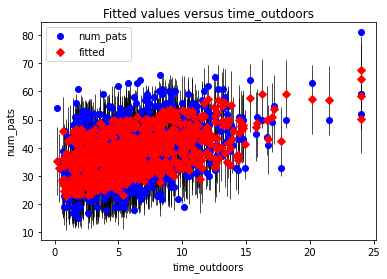

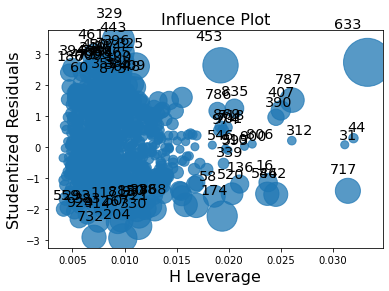

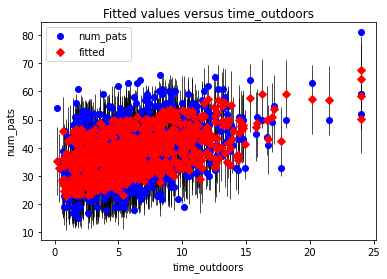

In [141]:
sm.graphics.influence_plot(lm_4c, criterion="cooks")
sm.graphics.plot_fit(lm_4c,"time_outdoors")

In [18]:
cat_df[630:635]

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
630,5.295400,1,3.218232,23.496838,2.012904,7.362649,1,5.384057,21
631,6.012840,2,3.661022,22.772578,2.524154,7.528472,0,3.566861,40
632,5.805834,3,3.668990,22.697557,3.288929,7.941635,1,6.042446,35
633,24.000000,3,4.139343,23.515620,3.465041,8.343535,0,1.858150,81
634,13.037910,2,3.707755,23.864526,3.971520,8.490644,1,6.105874,39


In [19]:
cat_df.describe()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.035366,1.96700,3.991534,23.986785,3.256364,8.171950,0.494000,5.461403,38.086000
std,3.584645,0.81889,0.500643,1.140039,0.840721,0.468196,0.500214,1.903036,9.437567
min,0.154231,1.00000,2.430003,19.939328,1.616797,6.682087,0.000000,1.711976,15.000000
25%,3.350706,1.00000,3.668124,23.198559,2.625019,7.867283,0.000000,3.879987,31.000000
50%,5.396088,2.00000,3.997326,23.969937,3.318276,8.147573,0.000000,5.307417,38.000000
75%,8.008499,3.00000,4.333097,24.727161,3.854054,8.466936,1.000000,6.938242,44.000000
max,24.000000,3.00000,5.493976,28.184376,6.179538,9.769214,1.000000,12.573740,81.000000


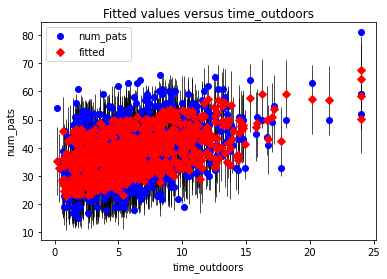

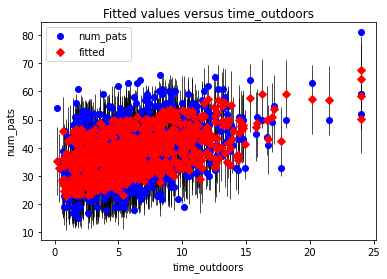

In [20]:
sm.graphics.plot_fit(lm_4c, "time_outdoors")

In [33]:
# Warning!
# ========
# We have to be very careful removing data or only work with copies of the
# dataframe.
cat_df_2 = cat_df.copy()
print(cat_df_2[632:635])
cat_df_2.drop([633], axis=0, inplace=True)
print(80 *"=")
print(cat_df_2[631:635])


#LEARNING
#R-squared = how much of the variability is explained 
#outliers can dominate the value of the coefficient 

     time_outdoors  coat_colour    weight     height  loudness  \
632       5.805834            3  3.668990  22.697557  3.288929   
633      24.000000            3  4.139343  23.515620  3.465041   
634      13.037910            2  3.707755  23.864526  3.971520   

     whisker_length  is_longhaired  coat_length  num_pats  
632        7.941635              1     6.042446        35  
633        8.343535              0     1.858150        81  
634        8.490644              1     6.105874        39  
     time_outdoors  coat_colour    weight     height  loudness  \
631       6.012840            2  3.661022  22.772578  2.524154   
632       5.805834            3  3.668990  22.697557  3.288929   
634      13.037910            2  3.707755  23.864526  3.971520   
635       4.295067            2  3.335932  25.702148  2.614308   

     whisker_length  is_longhaired  coat_length  num_pats  
631        7.528472              0     3.566861        40  
632        7.941635              1     6.042

In [143]:
lm_5 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) : coat_length", cat_df_2).fit()
print(lm_5.summary())
print(lm_4c.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     166.4
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          2.43e-177
Time:                        16:19:20   Log-Likelihood:                -3223.8
No. Observations:                 999   AIC:                             6466.
Df Residuals:                     990   BIC:                             6510.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Partial answer (enriched by Max)

- Point 633 did stand out due to the large amount of time spent outside and the large number of pats, but removing them had very little effect on the parameter estimates.
- While outliers can potentially dominate value of the coefficient some high leverage points have Y values right where they’d be predicted by a regression that was fit with the point excluded. These points aren’t particularly influential. While the size of bubble 633 appears big, it  seems that this is calculated relative to all other points. We can notice that scale of the influence plot has shrunk compared to  an earlier point in the analysis where we diagnosed the first outlier. At the same time, it is important to notice that R squared = 1  - RSS/TSS reflects this removal on both sides of the fraction so that the % variability explained might not significantly improve after removal unless the outlier had gravitational influence on the overall fit, which does not become apparent since the fitted line receives good stability from a cluttered area of points in the lower left


### Question 5 - Should a cat practise meowing or just spend more time outdoors to get more pats?


### Observations - Question 5   
- We can just look at the coefficients to see that a much more efficient way to get pats is to be outside, the relationship between loudness and number of pats is not supported by this data set.
- All things equal, we have to interpret the coefficients in the original units of our data and also acknowldge that the most influential predictor might not always be the easiest one to optimize for in practice. This opens the door to a separate discussion on statistical significance vs. practical significance / feasibility